# Recreating the paper Persistent‑homology‑based machine learning: a survey and a comparative study
- There are some problems with the approach (loosely described) in this paper: PDBs contain many SCOPe domains, and a domain is what SCOPe labels (so, noise).
- Chance of sampling similar PDBs is high.

## We download an example PDB

In [7]:
from Bio.PDB import PDBList

def download_pdb(pdb_id, outdir="pdbs"):
    pdbl = PDBList()
    # Format PDB ID as lowercase
    filename = pdbl.retrieve_pdb_file(pdb_id, pdir=outdir, file_format="pdb")
    print(f"Downloaded: {filename}")
    return filename

# Example:
download_pdb("1CRN")  # Crambin

Structure exists: 'pdbs/pdb1crn.ent' 
Downloaded: pdbs/pdb1crn.ent


'pdbs/pdb1crn.ent'

## Pointcloud and alpha complex plots

In [128]:
import numpy as np
from Bio.PDB import PDBParser
import plotly.graph_objects as go

def load_pointcloud_from_pdb(pdb_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("prot", pdb_path)
    coords = [atom.coord for atom in structure.get_atoms()]
    print(len(coords))
    return np.asarray(coords)  # (N, 3)

from Bio.PDB import PDBParser
import numpy as np

def ca_points(pdb_path, model_index=0, chain_id=None):
    """Return Cα coordinates for one model (and optionally one chain)."""
    structure = PDBParser(QUIET=True).get_structure("x", pdb_path)

    # Pick one model (many entries have multiple models for NMR ensembles)
    try:
        model = list(structure.get_models())[model_index]
    except IndexError:
        raise ValueError(f"Model index {model_index} not found in {pdb_path}")

    pts = []
    chains = [model[chain_id]] if chain_id is not None else model.get_chains()

    for ch in chains:
        for res in ch.get_residues():
            if not res.has_id('CA'):
                continue
            atom = res['CA']
            # handle alternate locations: prefer 'A' if present, else selected
            if atom.is_disordered():
                try:
                    atom = atom.disordered_get('A')
                except Exception:
                    atom = atom.selected_child
            pts.append(atom.coord)

    return np.asarray(pts, dtype=float)

filename = "pdbs_scope/46456/1agm.pdb" 
pointcloud = load_pointcloud_from_pdb(filename) 
ca_pointcloud = ca_points(filename)
# --- Build interactive 3D scatter ---
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=ca_pointcloud[:, 0],
            y=ca_pointcloud[:, 1],
            z=ca_pointcloud[:, 2],
            mode="markers",
            marker=dict(size=2, opacity=0.8),
            hoverinfo="skip",
        )
    ]
)

fig.update_layout(
    title="Protein Atom Point Cloud",
    scene=dict(
        xaxis_title="X", yaxis_title="Y", zaxis_title="Z",
        aspectmode="data"  # preserves real geometry
    ),
    margin=dict(l=0, r=0, t=30, b=0)
)

# --- Save as a standalone HTML you can open locally ---
fig.write_html("protein_pointcloud.html", include_plotlyjs="cdn", auto_open=False)
print("Wrote: protein_pointcloud.html")


4450
Wrote: protein_pointcloud.html


In [130]:
# pip install gudhi plotly biopython
import numpy as np
import plotly.graph_objects as go
import gudhi as gd

def alpha_complex_html(points, max_alpha_sq=np.inf, filename="alpha_complex.html"):
    # Build alpha complex
    ac = gd.AlphaComplex(points=points)
    st = ac.create_simplex_tree(max_alpha_square=max_alpha_sq)
    
    xs, ys, zs = points[:,0], points[:,1], points[:,2]
    fig = go.Figure()
    
    # Add vertices
    fig.add_trace(go.Scatter3d(
        x=xs, y=ys, z=zs,
        mode='markers',
        marker=dict(size=3, color='black'),
        name='Vertices'
    ))

    # Collect triangles for Mesh3d
    tri_i, tri_j, tri_k = [], [], []
    for simplex, filt in st.get_filtration():
        if len(simplex) == 2:  # edge
            i, j = simplex
            xi, yi, zi = points[i]
            xj, yj, zj = points[j]
            fig.add_trace(go.Scatter3d(
                x=[xi, xj], y=[yi, yj], z=[zi, zj],
                mode='lines',
                line=dict(width=1, color='blue'),
                opacity=0.5,
                showlegend=False
            ))
        elif len(simplex) == 3:  # triangle
            i, j, k = simplex
            tri_i.append(i); tri_j.append(j); tri_k.append(k)

    if tri_i:
        fig.add_trace(go.Mesh3d(
            x=xs, y=ys, z=zs,
            i=tri_i, j=tri_j, k=tri_k,
            opacity=0.5,
            color='lightblue',
            name='Triangles'
        ))

    fig.update_layout(
        title="Alpha Complex",
        scene=dict(aspectmode="data"),
        margin=dict(l=0, r=0, t=30, b=0)
    )

    # Save as standalone HTML
    fig.write_html(filename, include_plotlyjs="cdn")
    print(f"Saved: {filename}")

alpha_complex_html(ca_pointcloud, max_alpha_sq=20.0, filename="alpha_complex.html")

Saved: alpha_complex.html


In [31]:
from persistent_laplacians.eigenvalues import compute_eigenvalues
result = compute_eigenvalues(ca_pointcloud, num_indices=10, use_scipy=True, use_stepwise_schur=False, zero_tol=1e-6, max_dim=3)
result

Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x155a1c540>) }


/Users/marcelmasque/University/other/persistent_laplacians/python/persistent_laplacians/eigenvalues.py:12: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



{2: {(415, 934): [0.25488444155515794],
  (415, 622): [0.25488444155515794],
  (415, 415): [0.25488444155515794],
  (103, 726): [3.0],
  (103, 622): [3.0],
  (103, 518): [3.0],
  (518, 726): [0.5970494017820721],
  (0, 415): [],
  (103, 103): [3.0],
  (311, 415): [0.5063832268122944],
  (830, 830): [0.19492866298764921],
  (311, 311): [0.5063832268122944],
  (311, 622): [0.5063832268122944],
  (207, 518): [0.8299135133739656],
  (415, 518): [0.25488444155515794],
  (830, 934): [0.19492866362272573],
  (0, 830): [],
  (622, 934): [0.5431177322221672],
  (0, 934): [],
  (415, 726): [0.25488444155515794],
  (934, 934): [0.0636305874627884],
  (518, 830): [0.5970494017820721],
  (622, 622): [0.5431177322221672],
  (311, 830): [0.5063832268122944],
  (103, 311): [3.0],
  (207, 726): [0.8299135133739656],
  (622, 726): [0.5431177322221672],
  (0, 622): [],
  (0, 103): [],
  (207, 934): [0.8299135133739656],
  (103, 415): [3.0],
  (0, 726): [],
  (0, 0): [],
  (103, 830): [3.0],
  (518, 934):

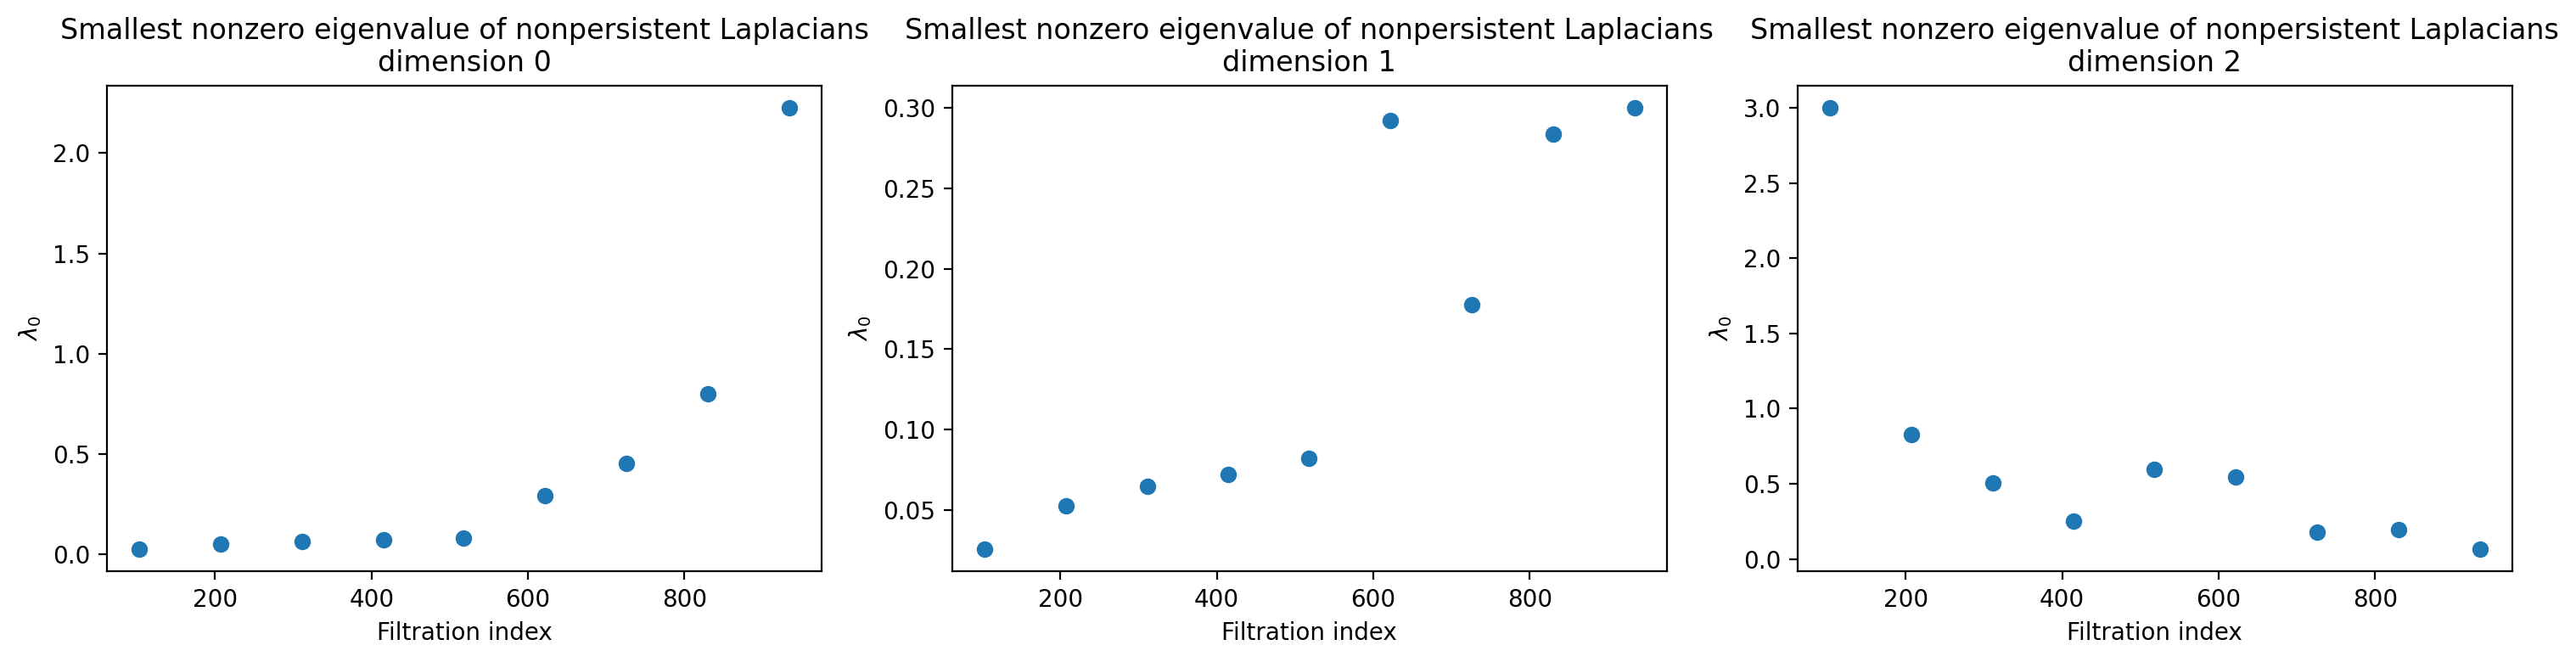

In [11]:
import matplotlib.pyplot as plt

dims = [0, 1, 2]
fig, axes = plt.subplots(1, len(dims), figsize=(5*len(dims), 4), dpi=200)

if len(dims) == 1:
    axes = [axes]

for ax, d in zip(axes, dims):
    nonpersistent = {k[0]: v[0] for (k, v) in result[d].items() if k[0] == k[1] and len(v) >= 1}
    ax.scatter(nonpersistent.keys(), nonpersistent.values())
    ax.set_title(r"Smallest nonzero eigenvalue of nonpersistent Laplacians"
                 + "\n" + f"dimension {d}")
    ax.set_xlabel("Filtration index")
    ax.set_ylabel(r"$\lambda_0$")

plt.tight_layout()
plt.show()

dict_items([((415, 934), [2.225485973229949]), ((207, 830), [0.8000127540129496]), ((103, 207), [0.05285140141671945]), ((311, 311), [0.06491831908120989]), ((311, 415), [0.07234582523820449]), ((934, 934), [2.2254859732299495]), ((518, 622), [0.2921569755489994]), ((207, 207), [0.05285140141671945]), ((103, 311), [0.06491831908121037]), ((311, 518), [0.08233814962331165]), ((207, 415), [0.07234582523820465]), ((103, 830), [0.8000127540129499]), ((103, 934), [2.225485973229948]), ((103, 103), [0.025541166257563832]), ((622, 726), [0.45599154161872474]), ((622, 622), [0.29215697554899944]), ((0, 726), [0.45599154161872446]), ((518, 934), [2.2254859732299486]), ((103, 622), [0.29215697554899933]), ((415, 830), [0.80001275401295]), ((311, 622), [0.29215697554899955]), ((830, 830), [0.8000127540129497]), ((311, 726), [0.45599154161872446]), ((103, 726), [0.45599154161872457]), ((103, 518), [0.0823381496233118]), ((0, 934), [2.22548597322995]), ((207, 311), [0.06491831908120985]), ((726, 93

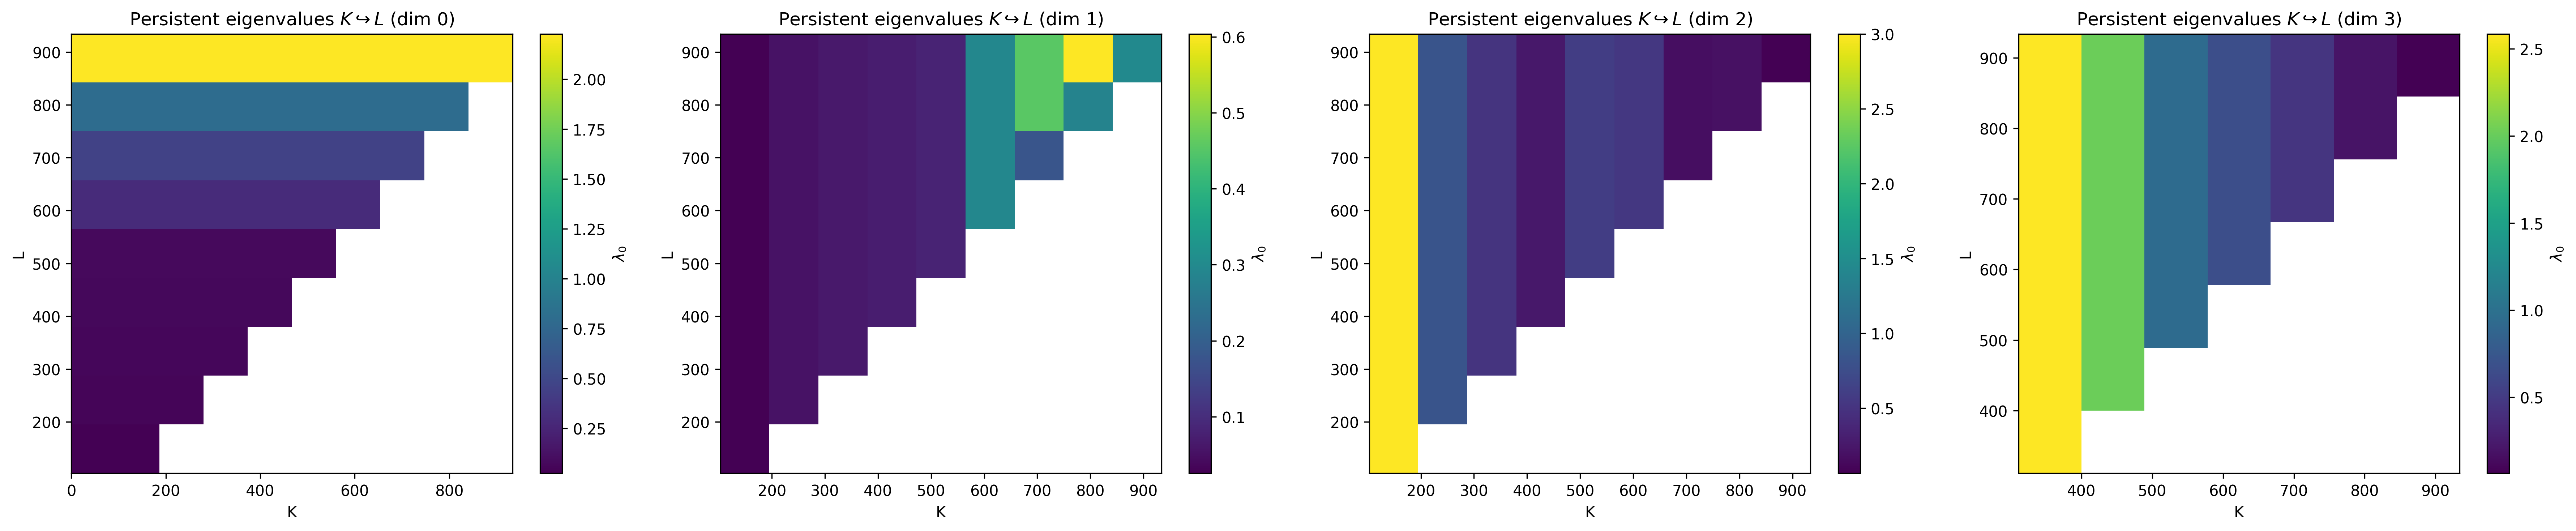

In [33]:
import numpy as np
import matplotlib.pyplot as plt

dims = [0, 1, 2, 3] 
fig, axes = plt.subplots(1, len(dims), figsize=(6*len(dims), 5), dpi=300)

if len(dims) == 1:
    axes = [axes]

for ax, d in zip(axes, dims):
    print(result[d].items())
    pts = {k: v for (k, v) in result[d].items() if len(v) >= 1}

    xs = sorted({x for x, y in pts})
    ys = sorted({y for x, y in pts})

    heat = np.full((len(ys), len(xs)), np.nan)
    x_i = {x:i for i,x in enumerate(xs)}
    y_i = {y:i for i,y in enumerate(ys)}

    for (x,y), v in pts.items():
        heat[y_i[y], x_i[x]] = v[0]

    im = ax.imshow(
        heat,
        origin='lower',
        extent=(min(xs), max(xs), min(ys), max(ys)),
        aspect='auto'
    )
    fig.colorbar(im, ax=ax, label=r'$\lambda_0$')
    ax.set_xlabel("K")
    ax.set_ylabel("L")
    ax.set_title(rf'Persistent eigenvalues $K \hookrightarrow L$ (dim {d})')

plt.tight_layout()
plt.show()

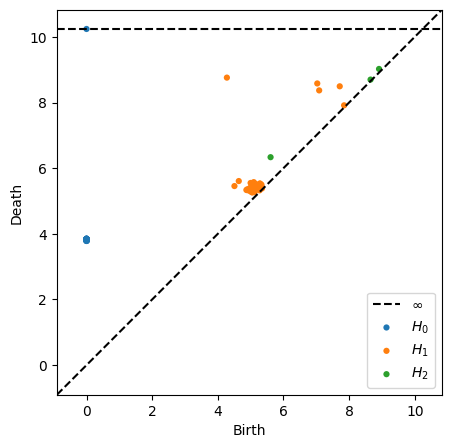

In [13]:
# pip install ripser persim
import numpy as np
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt

# --- Compute VR persistent homology up to H2 ---
result = ripser(
    ca_pointcloud,            # (N, d) array
    maxdim=2
)

diagrams = result['dgms']   # list of np.arrays: H0, H1, H2

# --- Plot persistence diagrams ---
plt.figure(figsize=(6,5))
plot_diagrams(diagrams, show=True)


## Query the PDB database for protein structures

We request PDBs for proteins in 3 SCOP lineages: alpha helixes, beta pleated sheets, alpha + beta.

In [74]:
# pip install requests
import json, random, requests
from pathlib import Path

SEARCH_URL = "https://search.rcsb.org/rcsbsearch/v2/query"  # GET with ?json=...
FILE_BASE  = "https://files.rcsb.org/download"              # for coordinate files

def find_pdbs_for_scope_fold(fold_code: str, n: int = 10, seed: int = 0, max_num_ca = 2000):
    """
    Return up to n PDB entry IDs that have a polymer entity annotated to SCOPe fold `fold_code`
    (e.g. "b.1"), and fewer than 2000 Cα atoms (residues).
    """
    payload = {
        "query": {
            "type": "group",
            "nodes": [
                {
                    "type": "group",
                    "nodes": [
                        {
                            "type": "group",
                            "nodes": [
                                {
                                    "type": "group",
                                    "nodes": [
                                        {
                                            "type": "terminal",
                                            "service": "text",
                                            "parameters": {
                                                "attribute": "rcsb_polymer_instance_annotation.annotation_lineage.id",
                                                "operator": "exact_match",
                                                "value": fold_code
                                            }
                                        },
                                        {
                                            "type": "terminal",
                                            "service": "text",
                                            "parameters": {
                                                "attribute": "rcsb_polymer_instance_annotation.type",
                                                "operator": "exact_match",
                                                "value": "SCOP"
                                            }
                                        }
                                    ],
                                    "logical_operator": "and",
                                    "label": "nested-attribute"
                                },
                                {
                                    "type": "terminal",
                                    "service": "text",
                                    "parameters": {
                                        "attribute": "rcsb_entry_info.deposited_polymer_monomer_count",
                                        "operator": "less",
                                        "value": max_num_ca
                                    }
                                }
                            ],
                            "logical_operator": "and"
                        }
                    ],
                    "logical_operator": "and",
                    "label": "text"
                }
            ],
            "logical_operator": "and"
        },
        "return_type": "entry",
        "request_options": {
            "paginate": {
                "start": 0,
                "rows": 5000
            },
            "results_content_type": ["experimental"],
            "sort": [{"sort_by": "score", "direction": "desc"}],
            "scoring_strategy": "combined"
        }
    }

    r = requests.get(SEARCH_URL, params={"json": json.dumps(payload)}, timeout=30)
    r.raise_for_status()
    hits = [h["identifier"] for h in r.json().get("result_set", []) if "identifier" in h]

    pdb_ids = sorted({hid.split("_", 1)[0] for hid in hits})
    random.seed(seed)
    return random.sample(pdb_ids, k=min(n, len(pdb_ids)))

def download_pdb(pdb_id: str, outdir: Path) -> Path:
    """
    Download <pdb_id>.pdb and save as lowercase .pdb.
    If file already exists, skip downloading.
    """
    outdir.mkdir(parents=True, exist_ok=True)
    dest = outdir / f"{pdb_id.lower()}.pdb"
    if dest.exists():
        print(f"⏩ Skipping {pdb_id}, already exists at {dest}")
        return dest

    url = f"{FILE_BASE}/{pdb_id}.pdb"
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()  # will error if no legacy .pdb exists for that entry
    dest.write_bytes(resp.content)
    return dest

def fetch_and_download_by_folds(folds, n_per_fold=10, base_out="pdbs_by_fold", seed=0, max_num_ca=2000):
    base = Path(base_out)
    results = {}
    for fold in folds:
        print(f"\nSearching fold {fold} …")
        pdbs = find_pdbs_for_scope_fold(fold, n=n_per_fold, seed=seed, max_num_ca=max_num_ca)
        print(f"Found {len(pdbs)} PDBs: {', '.join(pdbs) if pdbs else '(none)'}")
        saved = []
        for pid in pdbs:
            try:
                path = download_pdb(pid, base / fold.replace("/", "_"))
                print(f"Saved: {path}")
                saved.append(str(path))
            except Exception as e:
                print(f"⚠️  {pid}: {e}")
        results[fold] = saved
    return results

if __name__ == "__main__":
    alpha = "46456"
    beta = "48724"
    mixed_alpha_plus_beta = "53931"
    folds = [alpha, beta, mixed_alpha_plus_beta]
    fetch_and_download_by_folds(folds, n_per_fold=200, base_out="pdbs_scope", seed=0, max_num_ca=500)



Searching fold 46456 …
Found 200 PDBs: 1YMB, 2AX8, 1BWO, 1PRU, 2H9C, 2FAP, 1ZQM, 1SPG, 2EUQ, 1WMU, 2NAZ, 1N69, 2GRR, 1I6X, 1RCI, 1I7Y, 1FC2, 1PAR, 2J7X, 2OVV, 1IQ5, 1T6I, 1FK7, 1DWR, 1UI5, 2EFL, 2LDO, 1FPS, 1WGN, 2BU6, 1TJC, 1MK8, 2KSC, 2EUT, 2CIX, 2HYV, 1PUF, 1D3U, 2KFX, 1AIL, 1F7C, 1ZAV, 10GS, 2FVF, 1UPG, 1OXB, 1U9O, 1D8K, 1LRI, 2LXS, 1NEQ, 1OP1, 1IG6, 2JZY, 2CRG, 1F44, 1EF4, 1TTX, 2GZJ, 2FKX, 1GDK, 1SKN, 2KOO, 1RZL, 1H9E, 2KAY, 1UOU, 2JUW, 1MID, 2P1A, 2K9N, 2NTO, 1RQV, 2CNP, 1F4M, 2OH9, 1YLF, 1TL6, 2MGL, 1OV9, 1RYK, 1LC2, 1LKY, 1LH2, 1BH9, 1PU7, 2EUP, 1DPR, 1F1C, 1HME, 1IT5, 1BT3, 1EE5, 2JV3, 1YVT, 2ICT, 1R1X, 2HZA, 1OFC, 1N00, 2O38, 2AUQ, 2MZE, 1R1T, 2CUJ, 2FS1, 1WLA, 1EIJ, 1U84, 1GS9, 2FBK, 2NSR, 1UTR, 1LN8, 1OWG, 1ALU, 1QPU, 1GV3, 1NAX, 1XNN, 1K79, 1UOM, 2B9Z, 1D2T, 1IO3, 1N75, 1CCB, 2MES, 2JCG, 2OWI, 1DWT, 1BAJ, 1H96, 1LJW, 2PAQ, 2MGU, 1H0N, 1YVI, 1F4K, 1XHM, 1GT0, 1BOD, 2P7G, 1AX8, 1M1Q, 1LEA, 1H7I, 2EZA, 1MSE, 1CYJ, 1B0B, 2K3S, 2B8Z, 1FS7, 1PU6, 1DSO, 1NBP, 1DUX, 1SJ8, 1W4K, 

In [75]:
import os
import glob

def find_pdbs_by_sunid(root_dir="pdb_scope"):
    """
    Collects PDB files under `root_dir/<sunid>/*.pdb`.
    Returns:
        files:  list[str]  — PDB file paths
        labels: list[str]  — sunid (as string), aligned with files
    """
    files, labels = [], []
    for sunid in os.listdir(root_dir):
        sunid_path = os.path.join(root_dir, sunid)
        if not os.path.isdir(sunid_path):
            continue
        pattern = os.path.join(sunid_path, "*.pdb")
        for f in glob.glob(pattern):
            files.append(f)
            labels.append(sunid)  # label = folder name (sunid)
    if not files:
        raise RuntimeError(f"No PDBs found under {root_dir}/<sunid>/*.pdb")
    return files, labels

## Train a random forest classifier on the PDBs

In [76]:
# Classifier
import numpy as np
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
def cross_validation_from_features(features, y):
    X = features
    print("Shape:", X.shape)

    clf = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(clf, X, y, cv=cv,
                            scoring=["accuracy","f1_weighted"],
                            n_jobs=-1, return_estimator=False)

    a, f = scores["test_accuracy"], scores["test_f1_weighted"]
    print(f"Accuracy  {a.mean():.4f} ± {a.std():.4f} | folds: {a}")
    print(f"F1-weight {f.mean():.4f} ± {f.std():.4f} | folds: {f}")

In [77]:
# Feature extractor in parallel
import numpy as np
from joblib import Parallel, delayed

def compute_features_parallel(feature_extractor, images):
    X = np.vstack(Parallel(n_jobs=8, backend="loky")(
        delayed(feature_extractor)(im) for im in images
    ))
    return X

In [116]:
def feature_nonzero_eigenvalues(filename, num_nonzero_eigenvalues=1, max_dim=2):
    ca_pointcloud = ca_points(filename)
    result = compute_eigenvalues(ca_pointcloud, 
                                 num_indices=10, 
                                 use_scipy=True, 
                                 use_stepwise_schur=False, 
                                 zero_tol=1e-6, 
                                 max_dim=max_dim, 
                                 split_up_down=True,
                                 num_nonzero_eigenvalues=num_nonzero_eigenvalues)
    return result

def pad_vector(vec, target_len):
    """Pad vec with zeros on the right to length target_len."""
    vec = np.asarray(vec)
    if vec.shape[0] < target_len:
        return np.pad(vec, (0, target_len - vec.shape[0]))
    else:
        return vec[:target_len]

def flatten(result, num_nonzero_eigenvalues=1, dim=1):
    result_dim = result[dim]
    flattened = []
    # sort by key first
    for key, vec_pair in sorted(result_dim.items(), key=lambda kv: kv[0]):
        v1, v2 = vec_pair
        v1_padded = pad_vector(v1, num_nonzero_eigenvalues)
        v2_padded = pad_vector(v2, num_nonzero_eigenvalues)
        concatenated = np.concatenate([v1_padded, v2_padded])
        flattened.append(concatenated)
    return np.concatenate(np.array(flattened))
    
def nonpersistent(result, num_nonzero_eigenvalues=1, dim=1):
    nonpersistent = [
        (k[0], v)
        for k, v in result[dim].items()
        if k[0] == k[1]
    ]
    nonpersistent.sort(key=lambda x: x[0])

    nonzero_eigs = []
    for _, vec_pair in nonpersistent:
        v1, v2 = vec_pair
        v1_padded = pad_vector(v1, num_nonzero_eigenvalues)
        v2_padded = pad_vector(v2, num_nonzero_eigenvalues)
        concatenated = np.concatenate([v1_padded, v2_padded])
        nonzero_eigs.append(concatenated)

    nonzero_eigs = np.concatenate(nonzero_eigs)
    return nonzero_eigs

In [79]:
file_names, y = find_pdbs_by_sunid("pdbs_scope")

In [132]:
# baseline: homology
import gudhi as gd
import gudhi.representations

def persistence_image_dim_0(protein):
    complex = gd.AlphaComplex(protein)
    st = complex.create_simplex_tree(max_alpha_square=50)
    st.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[5,5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([st.persistence_intervals_in_dimension(0)])
    return pi.flatten()

def persistence_image_dim_1(protein):
    complex = gd.AlphaComplex(protein)
    st = complex.create_simplex_tree(max_alpha_square=50)
    st.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[5,5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([st.persistence_intervals_in_dimension(1)])
    return pi.flatten()

def persistence_image_dim_2(protein):
    complex = gd.AlphaComplex(protein)
    st = complex.create_simplex_tree(max_alpha_square=50)
    st.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[5,5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([st.persistence_intervals_in_dimension(2)])
    return pi.flatten()

X_dim0 = compute_features_parallel(lambda fn: persistence_image_dim_0(ca_points(fn)), file_names)
X_dim1 = compute_features_parallel(lambda fn: persistence_image_dim_1(ca_points(fn)), file_names)
X_dim2 = compute_features_parallel(lambda fn: persistence_image_dim_2(ca_points(fn)), file_names)
cross_validation_from_features(np.hstack([X_dim0, X_dim1, X_dim2]), y)

/Users/marcelmasque/University/other/persistent_laplacians/.venv/lib/python3.13/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: invalid value encountered in dot
  res = dot(at, bt)
/Users/marcelmasque/University/other/persistent_laplacians/.venv/lib/python3.13/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: invalid value encountered in dot
  res = dot(at, bt)
/Users/marcelmasque/University/other/persistent_laplacians/.venv/lib/python3.13/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: invalid value encountered in dot
  res = dot(at, bt)
/Users/marcelmasque/University/other/persistent_laplacians/.venv/lib/python3.13/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: invalid value encountered in dot
  res = dot(at, bt)
/Users/marcelmasque/University/other/persistent_laplacians/.venv/lib/python3.13/site-packages/numpy/_core/numeric.py:1211: RuntimeWarning: invalid value encountered in dot
  res = dot(at, bt)
/Users/marcelmasque/University/other/per

Shape: (600, 75)
Accuracy  0.5167 ± 0.0258 | folds: [0.49166667 0.55833333 0.50833333 0.49166667 0.53333333]
F1-weight 0.5157 ± 0.0261 | folds: [0.4914582  0.55938441 0.5071234  0.49050176 0.5298495 ]


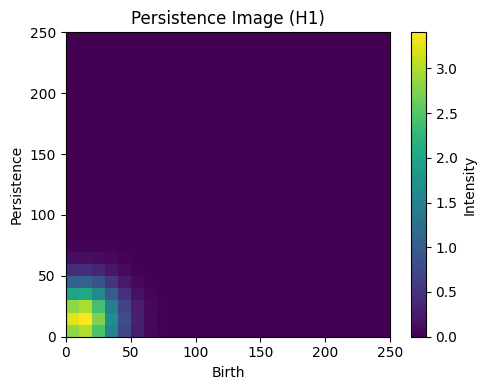

In [127]:
protein = ca_points("pdbs_scope/46456/1agm.pdb")
dimension = 1
complex = gd.AlphaComplex(protein)
st = complex.create_simplex_tree()
st.compute_persistence()
PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[25,25], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
pi = PI.fit_transform([st.persistence_intervals_in_dimension(dimension)])
img_flat = pi.flatten()
img = img_flat.reshape([25, 25])

fig, ax = plt.subplots(figsize=(5, 4))
# extent maps pixel coordinates back to (birth, persistence) axes
extent = [0, 250, 0, 250]
im = ax.imshow(img, origin="lower", extent=extent, aspect="auto")
ax.set_title(f"Persistence Image (H{dimension})")
ax.set_xlabel("Birth")
ax.set_ylabel("Persistence")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Intensity")
plt.tight_layout()
plt.show()

In [ ]:
num_nonzero_eigenvalues = 10

features = compute_features_parallel(
    lambda fn: feature_nonzero_eigenvalues(fn, num_nonzero_eigenvalues=num_nonzero_eigenvalues),
    file_names
)

In [95]:
features[0][0][1]

{(2128,
  3832): ([0.20912148363232208,
   0.30347222152666503,
   0.4287446040310984,
   0.48431212415294295,
   0.5737280304819775,
   0.6451225558579271,
   0.7333790095312868,
   0.8767966528549875,
   0.9727252009691512,
   1.0689077189841467], [0.5700179949024127,
   0.6873578347806609,
   0.7436777235905562,
   0.7933930226068036,
   0.9091756524212032,
   0.9748335657477988,
   1.0239880424685008,
   1.0677082190322733,
   1.1043149769827796,
   1.1752774043968965]),
 (1277,
  3406): ([0.05234283329900898,
   0.059562748377772465,
   0.07377181898136885,
   0.09469718375619351,
   0.14442516778975972,
   0.17867538413205425,
   0.1937337830126821,
   0.20157903702354954,
   0.2509090072556224,
   0.27740153340932083], [0.7957361525387522,
   0.9781056520527335,
   1.1091812198484965,
   1.3341026931319888,
   1.4235611027471973,
   1.594913092874051,
   1.6922907761767727,
   1.7656237735463278,
   1.840869553141965,
   1.8591987838985877]),
 (2128,
  2128): ([0.209121483632322

In [120]:
nonpersistent_features_dim0 = np.array([nonpersistent(x[0], num_nonzero_eigenvalues=num_nonzero_eigenvalues, dim=0) for x in features])
nonpersistent_features_dim1 = np.array([nonpersistent(x[0], num_nonzero_eigenvalues=num_nonzero_eigenvalues, dim=1) for x in features])
nonpersistent_features_dim2 = np.array([nonpersistent(x[0], num_nonzero_eigenvalues=num_nonzero_eigenvalues, dim=2) for x in features])

In [121]:
persistent_features_dim0 = np.array([flatten(x[0], num_nonzero_eigenvalues=10, dim=0) for x in features])
persistent_features_dim1 = np.array([flatten(x[0], num_nonzero_eigenvalues=10, dim=1) for x in features])
persistent_features_dim2 = np.array([flatten(x[0], num_nonzero_eigenvalues=10, dim=2) for x in features])

In [118]:
persistent_features_dim1[0]

array([0.        , 0.        , 0.        , ..., 0.34884442, 0.37569299,
       0.42449098], shape=(1100,))

In [122]:
print("Cross validation for DIMENSION 0 nonpersistent eigenvalues (10)")
cross_validation_from_features(nonpersistent_features_dim0, y)

print("Cross validation for DIMENSION 1 nonpersistent eigenvalues (10)")
cross_validation_from_features(nonpersistent_features_dim1, y)

print("Cross validation for DIMENSION 2 nonpersistent eigenvalues (10)")
cross_validation_from_features(nonpersistent_features_dim2, y)

print("Cross validation for DIMENSION 0 and DIMENSION 1 and DIMENSION 2 nonpersistent eigenvalues (10 each)")
cross_validation_from_features(np.hstack([nonpersistent_features_dim0, nonpersistent_features_dim1, nonpersistent_features_dim2]), y)

print("Cross validation for DIMENSION 1 and DIMENSION 2 nonpersistent eigenvalues (10 each)")
cross_validation_from_features(np.hstack([nonpersistent_features_dim1, nonpersistent_features_dim2]), y)

print("Cross validation for DIMENSION 0 persistent eigenvalues (10)")
cross_validation_from_features(persistent_features_dim0, y)

print("Cross validation for DIMENSION 1 persistent eigenvalues (10)")
cross_validation_from_features(persistent_features_dim1, y)

print("Cross validation for DIMENSION 2 persistent eigenvalues (10)")
cross_validation_from_features(persistent_features_dim2, y)

print("Cross validation for DIMENSION 1 and DIMENSION 2 persistent eigenvalues (10 each)")
cross_validation_from_features(np.hstack([persistent_features_dim1, persistent_features_dim2]), y)

print("Cross validation for DIMENSION 0 and DIMENSION 1 and DIMENSION 2 persistent eigenvalues (10 each)")
cross_validation_from_features(np.hstack([persistent_features_dim0, persistent_features_dim1, persistent_features_dim2]), y)

Cross validation for DIMENSION 0 nonpersistent eigenvalues (10)
Shape: (600, 200)
Accuracy  0.7167 ± 0.0253 | folds: [0.75833333 0.725      0.68333333 0.7        0.71666667]
F1-weight 0.7126 ± 0.0246 | folds: [0.75413324 0.72221633 0.68518823 0.69162756 0.70989417]
Cross validation for DIMENSION 1 nonpersistent eigenvalues (10)
Shape: (600, 200)
Accuracy  0.8167 ± 0.0217 | folds: [0.84166667 0.825      0.78333333 0.8        0.83333333]
F1-weight 0.8153 ± 0.0204 | folds: [0.8405566  0.82169177 0.78339243 0.80144656 0.82945435]
Cross validation for DIMENSION 2 nonpersistent eigenvalues (10)
Shape: (600, 200)
Accuracy  0.8450 ± 0.0282 | folds: [0.9        0.83333333 0.84166667 0.825      0.825     ]
F1-weight 0.8452 ± 0.0279 | folds: [0.89996834 0.83176444 0.84130684 0.82684617 0.82589427]
Cross validation for DIMENSION 0 and DIMENSION 1 and DIMENSION 2 nonpersistent eigenvalues (10 each)
Shape: (600, 600)
Accuracy  0.8483 ± 0.0271 | folds: [0.9        0.825      0.83333333 0.83333333 0.8